In [36]:
import random
from random import shuffle

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib_fontja
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from ydata_profiling import ProfileReport

random.seed(42)


In [37]:
with open('newsCorpora.csv') as f:
  raw = f.readlines()

data = []
allow = set(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])
for line in raw:
  line = line.rstrip()
  id, title, url, publisher, category, story, hostname, timestamp = line.split('\t')
  if publisher not in allow:
    continue

  data.append('\t'.join([id, title, url, publisher, category, story, hostname, timestamp]))

shuffle(data)
train, val_test = train_test_split(data, test_size=0.2)
valid, test = train_test_split(val_test, test_size=0.5)

with open('train.txt', 'w') as f:
  f.write('\n'.join(train))

with open('valid.txt', 'w') as f:
  f.write('\n'.join(valid))

with open('test.txt', 'w') as f:
  f.write('\n'.join(test))

print(len(train), len(valid), len(test))


10684 1336 1336


## 51

In [38]:
for data in [train, valid, test]:
  for i in range(len(data)):
    data[i] = data[i].split('\t')

columns = ['id', 'title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp']
num_cols = ['id', 'timestamp']

train_df = pl.DataFrame(train, orient='row', schema=columns)
train_df = train_df.with_columns([pl.col(col).cast(int) for col in num_cols])

valid_df = pl.DataFrame(valid, orient='row', schema=columns)
valid_df = valid_df.with_columns([pl.col(col).cast(int) for col in num_cols])

test_df = pl.DataFrame(test, orient='row', schema=columns)
test_df = test_df.with_columns([pl.col(col).cast(int) for col in num_cols])


In [39]:
# ProfileReport(train_df.to_pandas()).to_notebook_iframe()


In [40]:
df = pl.concat([train_df, valid_df, test_df])


In [41]:
delete_cols = ['id', 'url', 'publisher']
cat_cols = ['story', 'hostname']
category_map = {
  'b': 0,
  't': 1,
  'e': 2,
  'm': 3,
}
category_map_inv = ['b', 't', 'e', 'm']

tv = TfidfVectorizer()
n_components = 50
tsvd = TruncatedSVD(n_components=n_components, random_state=42)
le = LabelEncoder()
ss = StandardScaler()

def feature_engineering(_df: pl.DataFrame) -> pl.DataFrame:
  df = _df.clone()
  df = df.drop(delete_cols)

  tfidf = tv.fit_transform(df.select(pl.col('title')).to_pandas()['title'])
  svd = tsvd.fit_transform(tfidf)

  svd_df = pl.DataFrame(svd, schema=[f'SVD_{i}' for i in range(n_components)], orient='row')

  time_df = df.select(pl.from_epoch('timestamp', time_unit='ms')).select(
    pl.col('timestamp').dt.year().alias('year'),
    pl.col('timestamp').dt.month().alias('month'),
    pl.col('timestamp').dt.day().alias('day'),
    pl.col('timestamp').dt.hour().alias('hour'),
    pl.col('timestamp').dt.minute().alias('minute'),
  )

  df = pl.concat([df, time_df, svd_df], how='horizontal')
  df = df.drop('title')

  for cat_col in cat_cols:
    group_df = df.group_by(cat_col).len()
    df = df.with_columns(pl.col(cat_col).replace(group_df[cat_col], group_df['len']).cast(int))

  columns = df.columns
  columns.remove('category')

  ss_df = pl.DataFrame(ss.fit_transform(df.select(pl.col(columns))), schema=columns, orient='row')
  ss_df = ss_df.with_columns(df.select(pl.col('category')))
  df = ss_df

  return df

df_ = feature_engineering(df)
df_ = df_.with_columns(pl.col('category').replace(category_map).cast(int))

train_df, val_test_df = df_[:len(train_df)], df_[len(train_df):]
valid_df, test_df = val_test_df[:len(valid_df)], val_test_df[len(valid_df):]

train_df.write_csv('train.feature.txt', include_header=False, separator='\t')
valid_df.write_csv('valid.feature.txt', include_header=False, separator='\t')
test_df.write_csv('test.feature.txt', include_header=False, separator='\t')


## 52

In [42]:
def LRmodel(params={}, seed=42) -> LogisticRegression:
  model = LogisticRegression(random_state=seed, **params)

  return model


In [43]:
model = LRmodel()

X_train = train_df.drop('category')
y_train = train_df['category']
X_valid = valid_df.drop('category')
y_valid = valid_df['category']
X_test = test_df.drop('category')
y_test = test_df['category']

model.fit(X_train, y_train)


LogisticRegression(random_state=42)

## 53

In [44]:
pred = model.predict_proba(X_valid)
display(pred)
pred = model.predict_proba(X_test)
display(pred)


array([[8.86963724e-02, 8.42135874e-01, 6.96508766e-03, 6.22026664e-02],
       [9.90454884e-01, 8.32792585e-03, 9.89512019e-06, 1.20729510e-03],
       [1.21761978e-01, 1.21223394e-01, 7.13622964e-01, 4.33916646e-02],
       ...,
       [3.89246622e-03, 3.74557600e-02, 9.46684217e-01, 1.19675571e-02],
       [9.95594895e-01, 4.35817053e-03, 1.32887151e-05, 3.36461834e-05],
       [5.35299470e-02, 6.05499812e-03, 9.38390650e-01, 2.02440504e-03]])

array([[3.35500900e-01, 6.63815665e-01, 2.47378396e-04, 4.36056942e-04],
       [7.16898925e-02, 1.78044131e-01, 3.22522058e-01, 4.27743919e-01],
       [6.60217721e-01, 1.62984029e-01, 1.41776281e-01, 3.50219688e-02],
       ...,
       [6.44771715e-01, 5.29192784e-02, 2.93372798e-01, 8.93620894e-03],
       [2.00798245e-02, 7.21484887e-03, 9.67549615e-01, 5.15571199e-03],
       [9.99852403e-01, 2.85028579e-06, 1.44645900e-04, 1.00968778e-07]])

## 54

In [45]:
train_pred = model.predict_proba(X_train).argmax(axis=1)
test_pred = pred.argmax(axis=1)
print(f1_score(y_train, train_pred, average='macro'))
print(f1_score(y_valid, test_pred, average='macro'))


0.68117770681562
0.26009621606774486


## 55

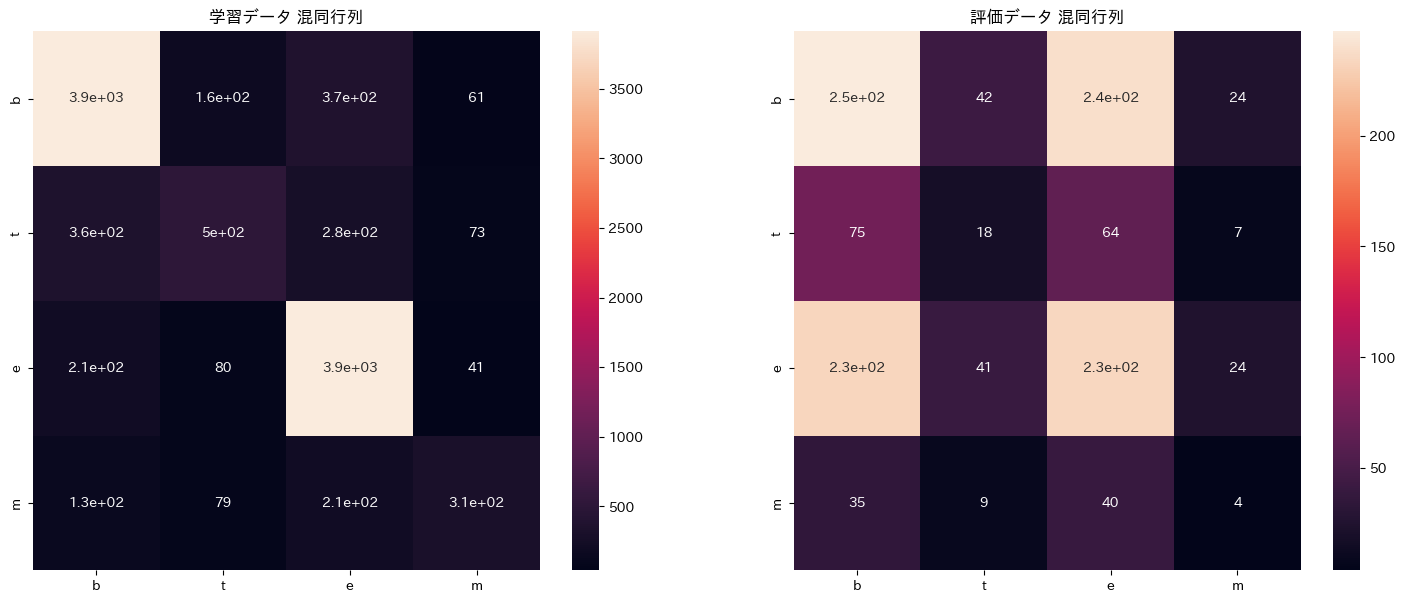

In [46]:
train_cm = confusion_matrix(y_train, train_pred)
test_cm = confusion_matrix(y_valid, test_pred)

fig, ax = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(train_cm, annot=True, ax=ax[0])
sns.heatmap(test_cm, annot=True, ax=ax[1])
ax[0].set_title('学習データ 混同行列')
ax[1].set_title('評価データ 混同行列')

for i in range(2):
  ax[i].set_xticklabels(category_map_inv)
  ax[i].set_yticklabels(category_map_inv)

plt.show()


## 56

In [47]:
names = []
p = []
r = []
f1 = []

for y_true, y_pred, name in [(y_train, train_pred, 'train_pred'), (y_valid, test_pred, 'valid_pred')]:
  for average in ['micro', 'macro']:
    names.append(f'{name} {average}')
    p.append(precision_score(y_true, y_pred, average=average))
    r.append(recall_score(y_true, y_pred, average=average))
    f1.append(f1_score(y_true, y_pred, average=average))


score_df = pl.DataFrame({
  'name': names,
  'precision score': p,
  'recall score': r,
  'f1 score': f1
})
score_df


name,precision score,recall score,f1 score
str,f64,f64,f64
"""train_pred micro""",0.807282,0.807282,0.807282
"""train_pred macro""",0.72843,0.65599,0.681178
"""valid_pred micro""",0.376497,0.376497,0.376497
"""valid_pred macro""",0.263906,0.260631,0.260096


## 57

In [48]:
## 各クラスについて重みが出るため、各クラスについての順位を出す

columns = np.array(X_train.columns)
for i, coef in enumerate(model.coef_):
  arg = np.abs(coef).argsort()
  print(f'クラス{category_map_inv[i]} 重み高 特徴量TOP10: {columns[arg][:10]}')
  print(f'クラス{category_map_inv[i]} 重み低 特徴量TOP10: {columns[arg][-10:][::-1]}')


クラスb 重み高 特徴量TOP10: ['year' 'SVD_46' 'month' 'minute' 'SVD_35' 'hostname' 'SVD_22' 'day'
 'timestamp' 'SVD_36']
クラスb 重み低 特徴量TOP10: ['SVD_1' 'SVD_6' 'story' 'SVD_4' 'SVD_8' 'SVD_3' 'SVD_0' 'SVD_29' 'SVD_30'
 'SVD_26']
クラスt 重み高 特徴量TOP10: ['year' 'SVD_48' 'SVD_45' 'SVD_0' 'day' 'hostname' 'timestamp' 'SVD_38'
 'hour' 'SVD_43']
クラスt 重み低 特徴量TOP10: ['SVD_6' 'SVD_8' 'SVD_11' 'SVD_24' 'SVD_29' 'SVD_2' 'SVD_15' 'SVD_39'
 'SVD_13' 'SVD_47']
クラスe 重み高 特徴量TOP10: ['year' 'SVD_42' 'hostname' 'SVD_9' 'SVD_49' 'SVD_10' 'day' 'SVD_46'
 'SVD_41' 'minute']
クラスe 重み低 特徴量TOP10: ['SVD_1' 'SVD_6' 'SVD_2' 'SVD_24' 'SVD_30' 'SVD_3' 'story' 'SVD_15'
 'SVD_8' 'SVD_39']
クラスm 重み高 特徴量TOP10: ['year' 'SVD_15' 'minute' 'hostname' 'SVD_20' 'SVD_44' 'timestamp' 'month'
 'SVD_47' 'SVD_14']
クラスm 重み低 特徴量TOP10: ['story' 'SVD_3' 'SVD_6' 'SVD_2' 'SVD_26' 'SVD_38' 'SVD_22' 'SVD_8'
 'SVD_34' 'SVD_30']


## 58

/home/uuekun/projects/media/100_nocks/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


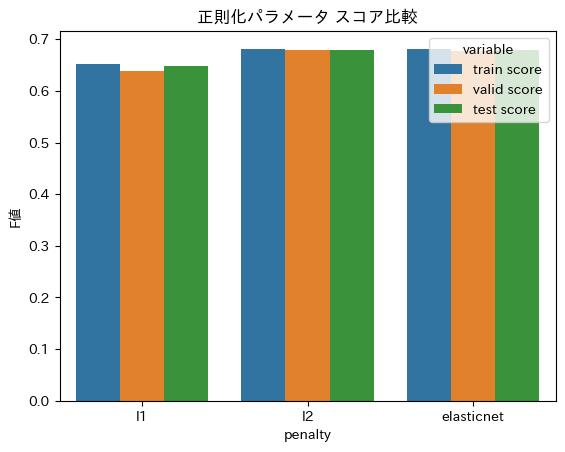

In [49]:
penalties = [('l1', 'liblinear'), ('l2', 'lbfgs'), ('elasticnet', 'saga')]
train_score = []
valid_score = []
test_score = []

for penalty, solver in penalties:
  params = {
    'penalty': penalty,
    'solver': solver,
  }
  if penalty == 'elasticnet':
    params['l1_ratio'] = 0.4

  model = LRmodel(params)
  model.fit(X_train, y_train)
  train_pred = model.predict_proba(X_train).argmax(axis=1)
  valid_pred = model.predict_proba(X_valid).argmax(axis=1)
  test_pred = model.predict_proba(X_test).argmax(axis=1)
  train_score.append(f1_score(y_train, train_pred, average='macro'))
  valid_score.append(f1_score(y_valid, valid_pred, average='macro'))
  test_score.append(f1_score(y_test, test_pred, average='macro'))

penalty_df = pl.DataFrame({
  'penalty': [i[0] for i in penalties],
  'train score': train_score,
  'valid score': valid_score,
  'test score': test_score
})

sns.barplot(penalty_df.unpivot(index='penalty'), x='penalty', y='value', hue='variable')
plt.title('正則化パラメータ スコア比較')
plt.ylabel('F値')
plt.show()


## 59

In [50]:
X_train_ = X_train.to_pandas()
y_train_ = y_train.to_pandas()
X_valid_ = X_valid.to_pandas()
y_valid_ = y_valid.to_pandas()
X_test_ = X_test.to_pandas()


In [51]:
def LGBMobjective(trial: optuna.trial.Trial):
  param = {
    'objective': 'multiclass',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
    "lambda_l2":         trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    "num_leaves":        trial.suggest_int("num_leaves", 2, 256),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    "feature_fraction":  trial.suggest_float("feature_fraction", 0.4, 1.0),
    "bagging_fraction":  trial.suggest_float("bagging_fraction", 0.4, 1.0),
    "bagging_freq":      trial.suggest_int("bagging_freq", 1, 7),
    "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    # "device":            "gpu"
  }


  model = lgb.LGBMClassifier(**param)
  # model = lgb.train(**param, lgb.Dataset(_train_df[t_train_cols], label=_train_df['ProdTaken']))
  model.fit(X_train_, y_train_, eval_set=[(X_valid_, y_valid_)])
  preds = model.predict_proba(X_test_).argmax(axis=1)
  score = f1_score(y_test, preds, average='macro')

  return score


In [52]:
def CATBobjective(trial: optuna.trial.Trial):
  params = {
    # "objective": trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
    "objective": 'MultiClass',
    "learning_rate" : trial.suggest_float("learning_rate", 0.01,0.3),
    # "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.1,1),
    "depth": trial.suggest_int("depth", 1, 12),
    # "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
    "iterations": trial.suggest_int("iterations", 500, 1000),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 5.0),
    "min_child_samples": trial.suggest_categorical("min_child_samples", [1, 4, 8, 16, 32]),
    "border_count": trial.suggest_int("border_count", 30, 250),
    "bootstrap_type": trial.suggest_categorical(
        "bootstrap_type", ["Bayesian", "Bernoulli"]
    ),
    "task_type": 'GPU',
    # "devices": 0,
  }

  if params['bootstrap_type'] == 'Bayesian':
    params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)

  if params['bootstrap_type'] == 'Bernoulli':
    params['subsample'] = trial.suggest_float('subsample', 0.1, 1)

  model = cb.CatBoostClassifier(**params)
  model.fit(X_train_, y_train_.to_numpy(), eval_set=[(X_valid_, y_valid.to_numpy())], verbose=0, early_stopping_rounds=100)
  preds = model.predict_proba(X_test_).argmax(axis=1)
  score = f1_score(y_test, preds, average='macro')

  return score


In [53]:
def XGBobjective(trial: optuna.trial.Trial):
  params = {
    'verbosity': 0,
    'objective': 'multi:softmax',
    'num_class': 4,
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
    'early_stopping_rounds': 100,
    'max_depth': trial.suggest_int('max_depth', 3, 10),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'tree_method': 'gpu_hist',
  }


  model = xgb.XGBClassifier(**params)
  model.fit(X_train_, y_train_.to_numpy(), eval_set=[(X_valid_, y_valid.to_numpy())])
  preds = model.predict_proba(X_test_).argmax(axis=1)
  score = f1_score(y_test, preds, average='macro')

  return score


In [54]:
OPTIMIZE = False

if OPTIMIZE:
  study = optuna.create_study(direction='maximize')
  study.optimize(XGBobjective, n_trials=300, timeout=1000)
  print("Number of finished trials: {}".format(len(study.trials)))
  print("Best trial:")
  trial = study.best_trial
  print("  Value: {}".format(trial.value))
  print("  Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


In [55]:
def LGBMmodel(seed=42):
  params = {
    'verbose': -1,
    'lambda_l1': 5.945636509691079e-06,
    'lambda_l2': 2.0830899122447362e-05,
    'num_leaves': 232,
    'learning_rate': 0.29737294717874346,
    'feature_fraction': 0.8902005409836046,
    'bagging_fraction': 0.9991912739108295,
    'bagging_freq': 2,
    'min_child_samples': 45,
  }

  model = lgb.LGBMClassifier(**params)
  return model

def CATBmodel(seed=42):
  params = {
    'verbose': 0,
    'learning_rate': 0.1513845266557987,
    'depth': 5,
    'iterations': 990,
    'l2_leaf_reg': 1.528337157184239,
    'min_child_samples': 32,
    'border_count': 61,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8378897070925617,
    "task_type": 'GPU',
  }

  model = cb.CatBoostClassifier(**params)
  return model

def XGBmodel(seed=42):
  params = {
    'verbosity': 0,
    'objective': 'multi:softmax',
    'num_class': 4,
    'early_stopping_rounds': 100,
    'learning_rate': 0.16447646602785473,
    'max_depth': 7,
    'min_child_weight': 3,
    'subsample': 0.939324676129164,
    'colsample_bytree': 0.6988438545351138,
    'tree_method': 'gpu_hist',
  }

  model = xgb.XGBClassifier(**params)
  return model


In [66]:
preds = []

for model_func in [LGBMmodel, CATBmodel, XGBmodel]:
  for seed in range(2):
    model = model_func(seed)
    X_train_ = X_train.to_pandas()
    y_train_ = y_train.to_pandas()
    X_valid_ = X_valid.to_pandas()
    y_valid_ = y_valid.to_pandas()
    X_test_ = X_test.to_pandas()
    model.fit(X_train_, y_train_, eval_set=[(X_valid_, y_valid_)])
    test_pred = model.predict_proba(X_test_)
    preds.append(test_pred)

preds = np.array(preds)
preds = preds.mean(axis=0).argmax(axis=1)
print(f1_score(y_test, preds, average='macro'))


[0]	validation_0-mlogloss:1.21811
[1]	validation_0-mlogloss:1.11736
[2]	validation_0-mlogloss:1.02047
[3]	validation_0-mlogloss:0.94385
[4]	validation_0-mlogloss:0.88638
[5]	validation_0-mlogloss:0.83034
[6]	validation_0-mlogloss:0.79249
[7]	validation_0-mlogloss:0.75540
[8]	validation_0-mlogloss:0.72157
[9]	validation_0-mlogloss:0.69315
[10]	validation_0-mlogloss:0.67288
[11]	validation_0-mlogloss:0.65220
[12]	validation_0-mlogloss:0.63587
[13]	validation_0-mlogloss:0.62111
[14]	validation_0-mlogloss:0.60933
[15]	validation_0-mlogloss:0.59878
[16]	validation_0-mlogloss:0.58835
[17]	validation_0-mlogloss:0.57994
[18]	validation_0-mlogloss:0.57217
[19]	validation_0-mlogloss:0.56399
[20]	validation_0-mlogloss:0.55541
[21]	validation_0-mlogloss:0.54823
[22]	validation_0-mlogloss:0.54431
[23]	validation_0-mlogloss:0.53846
[24]	validation_0-mlogloss:0.53281
[25]	validation_0-mlogloss:0.52823
[26]	validation_0-mlogloss:0.52513
[27]	validation_0-mlogloss:0.52195
[28]	validation_0-mlogloss:0.5